In [1]:
import os
import emc

import logging 
import pdb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn import preprocessing 

from matplotlib.ticker import StrMethodFormatter

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [4]:
# Print label counts
df['stroke'].value_counts()

# Data label is imbalanced

stroke
0    4861
1     249
Name: count, dtype: int64

In [5]:
# Fill in missing BMI data; use BMI means of each age quantile
q1 = df['age'].quantile(0.25)
q2 = df['age'].median()
q3 = df['age'].quantile(0.75)

q1_bmi = round(df[df['age']<=q1]['bmi'].mean(),1)
q2_bmi = round(df[(df['age']>q1)&(df['age']<=q2)]['bmi'].mean(),1)
q3_bmi = round(df[(df['age']>q2)&(df['age']<=q3)]['bmi'].mean(),1)
q4_bmi = round(df[df['age']>q3]['bmi'].mean(),1)

q1_bool_mask_sr = df[df['age']<=q1]['bmi'].isna()
q1_idx = q1_bool_mask_sr[q1_bool_mask_sr].index
df.loc[q1_idx,'bmi']=q1_bmi

q2_bool_mask_sr = df[(df['age']>q1)&(df['age']<=q2)]['bmi'].isna()
q2_idx = q2_bool_mask_sr[q2_bool_mask_sr].index
df.loc[q2_idx,'bmi']=q2_bmi

q3_bool_mask_sr = df[(df['age']>q2)&(df['age']<=q3)]['bmi'].isna()
q3_idx = q3_bool_mask_sr[q3_bool_mask_sr].index
df.loc[q3_idx,'bmi'] = q3_bmi

q4_bool_mask_sr = df[df['age']>q3]['bmi'].isna()
q4_idx = q4_bool_mask_sr[q4_bool_mask_sr].index
df.loc[q4_idx,'bmi'] = q4_bmi

### Categorical data

gender, ever_married, Residence_type => binary

work_type => one-hot (Nominal)

smoking_status => integer (Ordinal)

In [6]:
# Drop single row with "Other" gender value
df.drop(df[df['gender']=='Other'].index, inplace=True)

In [7]:
# Encode "work_type" column into one-hot
wt_category = pd.Categorical(df['work_type'], categories=['Private','Self-employed','Govt_job','children','Never_worked'])

# returns one-hot encoded df
one_hot_encoded = pd.get_dummies(wt_category).astype(int)

# Drop original work_type col
no_wt_df = df.drop('work_type', axis=1)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
numerical_df = pd.concat([no_wt_df.reset_index(drop=True), one_hot_encoded.reset_index(drop=True)], axis=1)

# Put stroke label column at the last columns
numerical_df = numerical_df[[c for c in numerical_df if c != 'stroke'] + [c for c in numerical_df if c == 'stroke']]

# Convert binary labeled columns into 0/1
numerical_df['gender'] = pd.factorize(numerical_df['gender'])[0]
numerical_df['ever_married'] = pd.factorize(numerical_df['ever_married'])[0]
numerical_df['Residence_type'] = pd.factorize(numerical_df['Residence_type'])[0]

In [8]:
# Convert smoking status to int
smoke_encoder = preprocessing.OrdinalEncoder(categories=[['never smoked','Unknown','formerly smoked','smokes']])

# Fit and transform the ordinal data
num_smoke_data = smoke_encoder.fit_transform(numerical_df['smoking_status'].values.reshape(-1,1))

numerical_df['smoking_status']=num_smoke_data.astype(int)

In [9]:
numerical_df['age'] = numerical_df['age'].astype(int)
numerical_df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,Private,Self-employed,Govt_job,children,Never_worked,stroke
0,9046,0,67,0,1,0,0,228.69,36.6,2,1,0,0,0,0,1
1,51676,1,61,0,0,0,1,202.21,31.6,0,0,1,0,0,0,1
2,31112,0,80,0,1,0,1,105.92,32.5,0,1,0,0,0,0,1


In [10]:
# Extract id column as a list
sample_id = numerical_df['id'].to_numpy()

# Drop id column as they are not used in training the model
numerical_df.drop(columns=['id'],inplace=True)

In [11]:
# Get label out before normalization
is_stroke = numerical_df['stroke'].values
numerical_df.drop(columns=['stroke'],inplace=True)

# Feature Normalization
numerical_df['bmi'] =  np.log(numerical_df['bmi'])
numerical_df['avg_glucose_level'] =  np.log(numerical_df['avg_glucose_level'])

scaler = preprocessing.StandardScaler().fit(numerical_df)
medical_data = scaler.transform(numerical_df)

In [12]:
print(medical_data.shape)
print(is_stroke.shape)
print(len(sample_id))

(5109, 14)
(5109,)
5109


## Splitting Imbalanced Data 
Our data is heavily imbalanced and it is important to balance the major and minor labels. \
Therefore, we do random oversampling of the minor class.


In [13]:
# Testing split function: Without validation set & sample_id
test_x, test_y, train_x, train_y = \
    emc.test_val_train_split_w_oversampling(medical_data, 
                                            is_stroke, 
                                            sample_id=None,
                                            oversample_type='smote',
                                            test_ratio=0.2,
                                            train_minor_label_oversample_ratio=0.2)

Input data's major & minor label ratio:
4860 : 249 = 95.13% : 4.87%

Test : Train
1021 :  4088

Train size before oversampling:  4088
Train size after oversampling:  4128

Resampled train data's major & minor label ratio:
3888 : 240 = 94.19% : 5.81%

Resampled data's test & train ratio:
1021 : 4128 = 19.83% : 80.17%



In [ ]:
# Create small balanced undersampled dataset for testing

major_label_idx_arr = np.where(is_stroke==0)[0]
minor_label_idx_arr = np.where(is_stroke==1)[0]
np.random.shuffle(major_label_idx_arr)

# slice major label index array to the same length as minor label index array
major_label_idx_arr = major_label_idx_arr[:len(minor_label_idx_arr)]

assert len(major_label_idx_arr)== len(minor_label_idx_arr)

small_medical_data = np.concatenate((medical_data[major_label_idx_arr], medical_data[minor_label_idx_arr]), axis=0)
small_is_stroke = np.concatenate((is_stroke[major_label_idx_arr], is_stroke[minor_label_idx_arr]), axis=0)
small_sample_id = np.concatenate((sample_id[major_label_idx_arr], sample_id[minor_label_idx_arr]), axis=0)

assert len(small_medical_data)==len(small_is_stroke)

print(f"small data shape: {small_medical_data.shape}\nsmall label shape: {small_is_stroke.shape}\nsmall sample id shape: {len(small_sample_id)}")

small data shape: (498, 14)
small label shape: (498,)
small sample id shape: 498


### Set up results directory and logger  

### Model configuration

In [15]:
# Configuration for both EMC and random sampling models
config={
    "emc_dir_path":None,
    "rand_sampling_dir_path":None,
    
    # number of emc or random sampling simulations to run
    "start_sim":None, # if None, start simulation from the 0 to n_sim
    "n_sim":10,
    
    # ratio [0.0,1.0] of samples to fit model before sampling
    "initial_train_ratio":0.05,
    
    # 'ros' OR 'smote' 
    "oversample_type":'smote',                  
    
    # ratio [0.0,1.0] OR number of samples
    "test_ratio":0.2,

    # ratio [0.0,1.0] OR number of samples
    "train_minor_label_oversample_ratio":0.2,
    
    "log_freq":20,
    "logger_rand_sampler":None,
    "logger_emc":None   
}

In [ ]:
# Make new directory to store results

# Set emc sampling results directory name
emc_dir_path = emc.make_unique_file_or_dir_name("stroke_emc_res")
os.mkdir(emc_dir_path)

# Set random sampling results directory name
rand_sampling_dir_path = emc.make_unique_file_or_dir_name("stroke_rand_sampling_res")
os.mkdir(rand_sampling_dir_path)

# Include paths in config
config['emc_dir_path'] = emc_dir_path
config['rand_sampling_dir_path'] = rand_sampling_dir_path

In [ ]:
# Manually set directory paths

# emc_dir_path="stroke_emc_res"
# rand_sampling_dir_path="stroke_rand_sampling_res"
# config['emc_dir_path'] = emc_dir_path
# config['rand_sampling_dir_path'] = rand_sampling_dir_path


In [17]:
# Set up logger for emc sampling simulation
logger_emc = logging.getLogger("emc_logger")
logger_emc.setLevel(logging.INFO)

# logger formatter
emc_formatter = logging.Formatter('%(asctime)s %(message)s', datefmt='%Y-%m-%d %H:%M')
emc_file_handler = logging.FileHandler(f"{emc_dir_path}/emc.log")
emc_file_handler.setFormatter(emc_formatter)

logger_emc.addHandler(emc_file_handler)

In [18]:
# Set up logger for random sampling simulation
logger_rand_sampler = logging.getLogger("rand_sampler_logger")
logger_rand_sampler.setLevel(logging.INFO)

rand_formatter = logging.Formatter('%(asctime)s %(message)s', datefmt='%Y-%m-%d %H:%M')
rand_file_handler = logging.FileHandler(f"{rand_sampling_dir_path}/rand_sampling.log")
rand_file_handler.setFormatter(rand_formatter)

logger_rand_sampler.addHandler(rand_file_handler)

In [19]:
logger_emc.propagate = False
logger_rand_sampler.propagate = False

# Add logger objects to config
config['logger_emc']=logger_emc
config['logger_rand_sampler']=logger_rand_sampler

### Run Logistic Regression and Expected Model Change
Logistic regression will be our base learner for this project.

In [ ]:
# EMC simulation on small test case data
emc.run_l_simulations_emc(data_x=small_medical_data, 
                          label_y=small_is_stroke, 
                          sample_id=small_sample_id, 
                          **config)

# EMC simulation on whole data
# emc.run_l_simulations_emc(data_x=medical_data, label_y=is_stroke, sample_id=sample_id, **config)

In [ ]:
# Random Sampling simulation on small test case data
emc.run_n_simulations_random_sampling(data_x=small_medical_data, 
                                      label_y=small_is_stroke,
                                      **config)

# Random Sampling simulation on whole data
# emc.run_n_simulations_random_sampling(a_x=medical_data, label_y=is_stroke, **config)

In [24]:
# Load EMC results
n_sim_accuracy_ls, n_sim_precision_ls, n_sim_recall_ls = [],[],[]

for i in range(config['n_sim']):
    n_sim_accuracy_ls.append(np.load(f"{config['emc_dir_path']}/{i}_sim_emc_accuracy.npy"))
    n_sim_precision_ls.append(np.load(f"{config['emc_dir_path']}/{i}_sim_emc_precision.npy"))
    n_sim_recall_ls.append(np.load(f"{config['emc_dir_path']}/{i}_sim_emc_recall.npy"))

In [25]:
# Load Random Sampling results
n_sim_accuracy_random_ls, n_sim_precision_random_ls, n_sim_recall_random_ls = [],[],[]

for i in range(config['n_sim']):
    n_sim_accuracy_random_ls.append(np.load(f"{config['rand_sampling_dir_path']}/{i}_sim_rand_sample_accuracy.npy"))
    n_sim_precision_random_ls.append(np.load(f"{config['rand_sampling_dir_path']}/{i}_sim_rand_sample_precision.npy"))
    n_sim_recall_random_ls.append(np.load(f"{config['rand_sampling_dir_path']}/{i}_sim_rand_sample_recall.npy"))

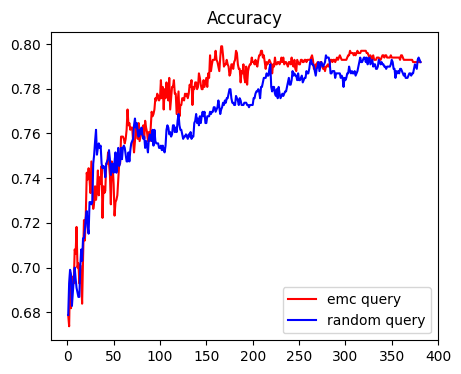

In [40]:
n_updates =  len(n_sim_accuracy_ls[0])

plt.figure(figsize=(5,4))
emc.plot_metrics(n_sim_accuracy_ls, n_updates, plot_separate_sim=False, color='red', label='emc query')
emc.plot_metrics(n_sim_accuracy_random_ls, n_updates, plot_separate_sim=False, color='blue', label='random query')
plt.title('Accuracy')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.show()

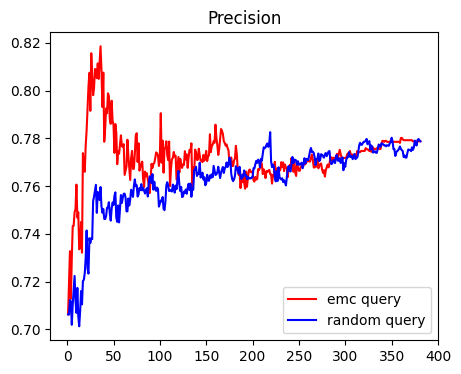

In [41]:
plt.figure(figsize=(5,4))
emc.plot_metrics(n_sim_precision_ls, n_updates, plot_separate_sim=False, color='red', label='emc query')
emc.plot_metrics(n_sim_precision_random_ls, n_updates, plot_separate_sim=False, color='blue', label='random query')
plt.title('Precision')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.show()

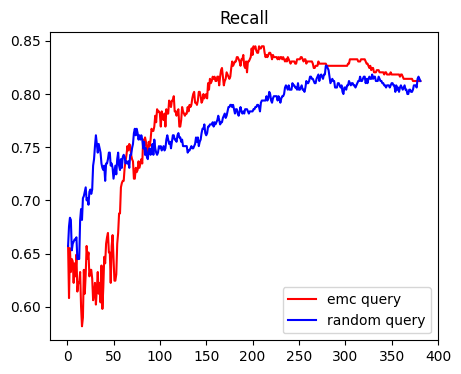

In [42]:
plt.figure(figsize=(5,4))
emc.plot_metrics(n_sim_recall_ls, n_updates, plot_separate_sim=False, color='red', label='emc query')
emc.plot_metrics(n_sim_recall_random_ls, n_updates, plot_separate_sim=False, color='blue', label='random query')
plt.title('Recall')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Performance comparison to no-sampling model
# Testing split function: Without validation set & sample_id
test_x, test_y, train_x, train_y = \
    emc.test_val_train_split_w_oversampling(small_medical_data, 
                                            small_is_stroke, 
                                            sample_id=None,
                                            oversample_type='smote',
                                            test_ratio=0.2,
                                            train_minor_label_oversample_ratio=0.2)

model = LogisticRegression(max_iter=1000)
model.fit(train_x, train_y)
model_pred = model.predict(test_x)

# Classification metrics
model_accuracy = accuracy_score(test_y, model_pred)
model_precision = precision_score(test_y, model_pred)
model_recall = recall_score(test_y, model_pred)

print(f"Model accuracy: {round(model_accuracy,2)}\nModel precision: {round(model_precision,2)}\nModel recall: {round(model_recall,2)}")

Input data's major & minor label ratio:
249 : 249 = 50.0% : 50.0%

Test : Train
99 :  399

Train size before oversampling:  399
Train size after oversampling:  400

Resampled train data's major & minor label ratio:
200 : 200 = 50.0% : 50.0%

Resampled data's test & train ratio:
99 : 400 = 19.84% : 80.16%

Model accuracy: 0.8
Model precision: 0.81
Model recall: 0.78
